In [1]:


import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 



In [2]:



sys.path.append("../../LPP/LPP_package/")

from lpp_package.data.language_data import LanguageData
from lpp_package.data.preprocess import preprocess_data
from lpp_package.models.regression_estimators import RegressionEstimators
from lpp_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results





In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/LPP/Models"),
    "results_path": Path("/home/soroosh/Programmes/LPP/Results"),
    "figures_path": Path("/home/soroosh/Programmes/LPP/Figures"),
    "params_path": Path("/home/soroosh/Programmes/LPP/Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="lpp_nationalities_all_fix_demo"

estimator_name = "rf_cls"
to_shuffle = True
to_exclude_at_risk = 0
pp = "mm"


In [5]:

specifier = data_name + "-" + estimator_name + "--shuffled:" + str(to_shuffle)



In [6]:


configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'lpp_nationalities_all_fix_demo-rf_cls--shuffled:True'

## Load Data

In [8]:


lpp = LanguageData(path="../../LPP/datasets_LPP/",
                   n_repeats=5, 
                   data_name=data_name)




In [12]:
# Determine which dataset to use, e.g. demo dataset
# alone or concatenation of demo and IA_report, for instance.
if data_name == "lpp_ru_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    demo = lpp.get_ru_fix_demo_datasets()  # demos and fixation

    df_data_to_use = demo.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration', 'motiv', 'IQ',
                                  'Age', 'Sex', 'Target_Ave', 'Target_Label']]
    c_features = ['Sex']
    indicators = ['SubjectID']
    targets = ['Target_Ave', 'Target_Label']

elif data_name == "lpp_all_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    demo = lpp.get_all_fix_demo_datasets()  # demos and fixation

    df_data_to_use = demo.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration', 'motiv', 'IQ',
                                  'Age', 'Sex', 'Target_Ave', 'Target_Label']]
    c_features = ['Sex']
    indicators = ['SubjectID']
    targets = ['Target_Ave', 'Target_Label']

elif data_name == "lpp_ru_fix":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    demo = lpp.get_ru_fix_demo_datasets()  # demos and fixation
    df_data_to_use = demo.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration',
                                  'Target_Ave', 'Target_Label']] # fixation data only
    c_features = []
    indicators = ['SubjectID']
    targets = ['Target_Ave', 'Target_Label']

elif data_name == "lpp_all_fix":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    demo = lpp.get_all_fix_demo_datasets()  # demos and fixation
    df_data_to_use = demo.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration',
                                  'Target_Ave', 'Target_Label']] # fixation data only
    c_features = []
    indicators = ['SubjectID']
    targets = ['Target_Ave', 'Target_Label']


elif data_name == "lpp_nationalities_all_fix_demo":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    tmp_d = pd.read_csv("../../LPP/datasets_LPP/lpp_nationalities_all_fix_demo.csv")  

    df_data_to_use = tmp_d.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration', 'motiv', 'IQ',
                                  'Age', 'Sex', 'Language']
                              ]
    c_features = ['Sex']
    indicators = ['SubjectID']
    targets = ['Language'] 
    
    class_names = list(df_data_to_use.Language.unique())


    
# Later we should add other language getters or
#   at-least one more getter for whole of the nations under consideration.
else:
    print("data_name argument:", data_name)
    assert False, "Ill-defined data_name argument. Refer to help of data_name argument for more."


In [13]:

df_data_to_use.head()



,Fix_X,Fix_Y,Fix_Duration,motiv,IQ,Age,Sex,Language
0,103,123,48,3.8,6.0,19,0,du
1,366,152,96,3.8,6.0,19,0,du
2,250,135,117,3.8,6.0,19,0,du
3,175,123,264,3.8,6.0,19,0,du
4,226,119,155,3.8,6.0,19,0,du


In [14]:

x_org, y_org = lpp.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)


In [15]:
x_org

,IQ,Fix_Y,Sex_0,Age,Sex_1,Fix_Duration,Fix_X,motiv
0,6.0,123,True,19,False,48,103,3.8
1,6.0,152,True,19,False,96,366,3.8
2,6.0,135,True,19,False,117,250,3.8
3,6.0,123,True,19,False,264,175,3.8
4,6.0,119,True,19,False,155,226,3.8
...,...,...,...,...,...,...,...,...
1080280,9.0,494,True,24,False,188,748,3.5
1080281,9.0,492,True,24,False,220,886,3.5
1080282,9.0,494,True,24,False,181,959,3.5
1080283,9.0,491,True,24,False,133,1049,3.5


In [16]:



y_org



,Language
0,du
1,du
2,du
3,du
4,du
...,...
1080280,tr
1080281,tr
1080282,tr
1080283,tr


In [17]:


print("x_org:", x_org.shape, "\n", x_org.head())


if estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    from lpp_package.models.classification_estimators import ClassificationEstimators

    
    y_org.replace(to_replace={"Language":
                          {'du':1, 'ee':2, 'fi':3, 'ge':4, 
                          'gr':5, 'he':6, 'it':7, 'no':8,
                          'ru':9, 'sp':10, 'tr':11}
                         }, inplace=True), 
    
    y = y_org.Language.values


else:
    assert False, "Undefined algorithm and thus undefined target values"

if to_shuffle == 1:
    to_shuffle = True
    group = learning_method + "-" + "shuffled"
else:
    to_shuffle = False
    group = learning_method + "-" + "not-shuffled"


x_org: (1080285, 8) 
     IQ  Fix_Y  Sex_0  Age  Sex_1  Fix_Duration  Fix_X  motiv
0  6.0    123   True   19  False            48    103    3.8
1  6.0    152   True   19  False            96    366    3.8
2  6.0    135   True   19  False           117    250    3.8
3  6.0    123   True   19  False           264    175    3.8
4  6.0    119   True   19  False           155    226    3.8


In [18]:
y_org.Language.values

array([ 1,  1,  1, ..., 11, 11, 11])

In [19]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (1080285, 8)


In [20]:
x




array([[0.45454545454545453, 0.33166726169225275, 1.0, ...,
        0.007748020885969345, 0.2464906019509874, 0.7272727272727271],
       [0.45454545454545453, 0.34202070689039626, 1.0, ...,
        0.015832912245241703, 0.30906495360456815, 0.7272727272727271],
       [0.45454545454545453, 0.33595144591217424, 1.0, ...,
        0.019370052214923363, 0.28146561979538426, 0.7272727272727271],
       ...,
       [0.7272727272727273, 0.4641199571581578, 1.0, ...,
        0.030149907360619843, 0.450154651439448, 0.5909090909090908],
       [0.7272727272727273, 0.4630489111031774, 1.0, ...,
        0.02206501600134748, 0.4715679276707114, 0.5909090909090908],
       [0.7272727272727273, 0.46126383434487683, 1.0, ...,
        0.01886474650496884, 0.450630502022365, 0.5909090909090908]],
      dtype=object)

In [21]:
y

array([ 1,  1,  1, ..., 11, 11, 11])

In [22]:

np.random.seed(43)
data = lpp.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Language.values,
        to_shuffle=to_shuffle,
        n_splits=configs.n_repeats
    )



In [23]:

data.keys()


dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [24]:
data

defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.45454545454545453, 0.33166726169225275, 1.0, ...,
                                  0.007748020885969345, 0.2464906019509874, 0.7272727272727271],
                                 [0.45454545454545453, 0.34202070689039626, 1.0, ...,
                                  0.015832912245241703, 0.30906495360456815, 0.7272727272727271],
                                 [0.45454545454545453, 0.33595144591217424, 1.0, ...,
                                  0.019370052214923363, 0.28146561979538426, 0.7272727272727271],
                                 ...,
                                 [0.7272727272727273, 0.4641199571581578, 1.0, ...,
                                  0.030149907360619843, 0.450154651439448, 0.5909090909090908],
                                 [0.7272727272727273, 0.4630489111031774, 1.0, ...,
                                  0.02206501600134748, 0.471567

## Load the tuned parameters OR weights

In [25]:

# tuned_params = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.params_path
#         )
# tuned_params


# dc_all_e.csv-knn_reg--shuffled:True


In [26]:


mdl = sklearn.ensemble.RandomForestClassifier(
    n_estimators=950, min_samples_leaf=2, min_samples_split=9
    , n_jobs=4, 
)

mdl


RandomForestClassifier(min_samples_leaf=2, min_samples_split=9,
                       n_estimators=950, n_jobs=4)

In [27]:


specifier



'lpp_nationalities_all_fix_demo-rf_cls--shuffled:True'

In [28]:

k_ = "4"
x_train = data[k_]["x_train"]
x_test = data[k_]["x_test"]
y_train = data[k_]["y_train"]
y_test = data[k_]["y_test"]





In [29]:


y_test




array([ 1,  1,  1, ..., 11, 11, 11])

In [30]:


class_names = y_org



In [32]:

# results = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.results_path,
#         )


# r2, mae = [], []

# for i in range(1, 11):
#     i = str(i)
#     y_test_ = results[i]["y_test"]
#     y_pred_ = results[i]["y_pred"]
    
#     tmp =  sklearn.metrics.r2_score(y_test_, y_pred_)
#     r2.append(tmp)
    
#     tmp2 = sklearn.metrics.mean_absolute_error(y_test_, y_pred_,)
#     mae.append(tmp2)
  
#     print(
#         f"R2: {tmp: .3f}",
        
#         f"MAE: {tmp2: .3f}"
#     )




In [34]:

# results[i]["y_pred"]
    


In [35]:


# y_test_




In [37]:


# print_the_evaluated_results(
#     results=results, 
#     learning_method=learning_method
# )




In [38]:


mdl.fit(x_train, y_train)




RandomForestClassifier(min_samples_leaf=2, min_samples_split=9,
                       n_estimators=950, n_jobs=4)

In [40]:

y_test[5:10:]



array([1, 1, 1, 1, 1])

In [41]:


mdl.predict(x_test[5:10:, :])





array([1, 1, 1, 1, 1])

In [52]:

sklearn.metrics.accuracy_score(y_test, 
                         mdl.predict(x_test)
                        )


0.9155134269501708

In [53]:


y_test




array([ 1,  1,  1, ..., 11, 11, 11])

In [54]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [55]:

idx_0 = np.where(y_train==0.)[0]
idx_1 = np.where(y_train==1.)[0]
idx_2 = np.where(y_train==2.)[0]
idx_3 = np.where(y_train==3.)[0]



In [56]:


background = shap.sample(x_train, 500) # data to train both explainers on




In [ ]:


background.shape


In [ ]:



explainer = shap.KernelExplainer(
    model=mdl.predict, 
    data=background,
    feature_names=list(x_org.columns), 
)

shap_values = explainer.shap_values(x_test,)




Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/108029 [00:00<?, ?it/s]

In [100]:



print("Shap values are determined!")



Shap values are determined!


In [101]:


len(shap_values)


108029

In [102]:


y_test.shape, x_test.shape, len(shap_values), shap_values[0].shape, 


((108029,), (108029, 8), 108029, (8,))

In [103]:

shap_values.shape



(108029, 8)

- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [104]:


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

RGB_val = 255

color01= (4,87,172)  # (0,255,255)  # Cyan wanted
color04= (244,230,4)  # (255,255,0)  # yellow wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
n = 256

# Start of the creation of the gradient
Color01= ListedColormap(Colors[0], name='Color01', N=None)
Color04= ListedColormap(Colors[1], name='Color04', N=None)
top = cm.get_cmap(Color01,128)
bottom = cm.get_cmap(Color04,128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]

GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                   np.linspace(mymin1, mymax1,  n),
                   np.linspace(mymin2, mymax2,  n),
                   np.linspace(mymin3, mymax3,  n)]

GradientBlueRed_res =np.transpose(GradientBlueRed)

# End of the creation of the gradient

# newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# shap.summary_plot(shap_values, x_test, color=newcmp)

# Create colormap
newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')




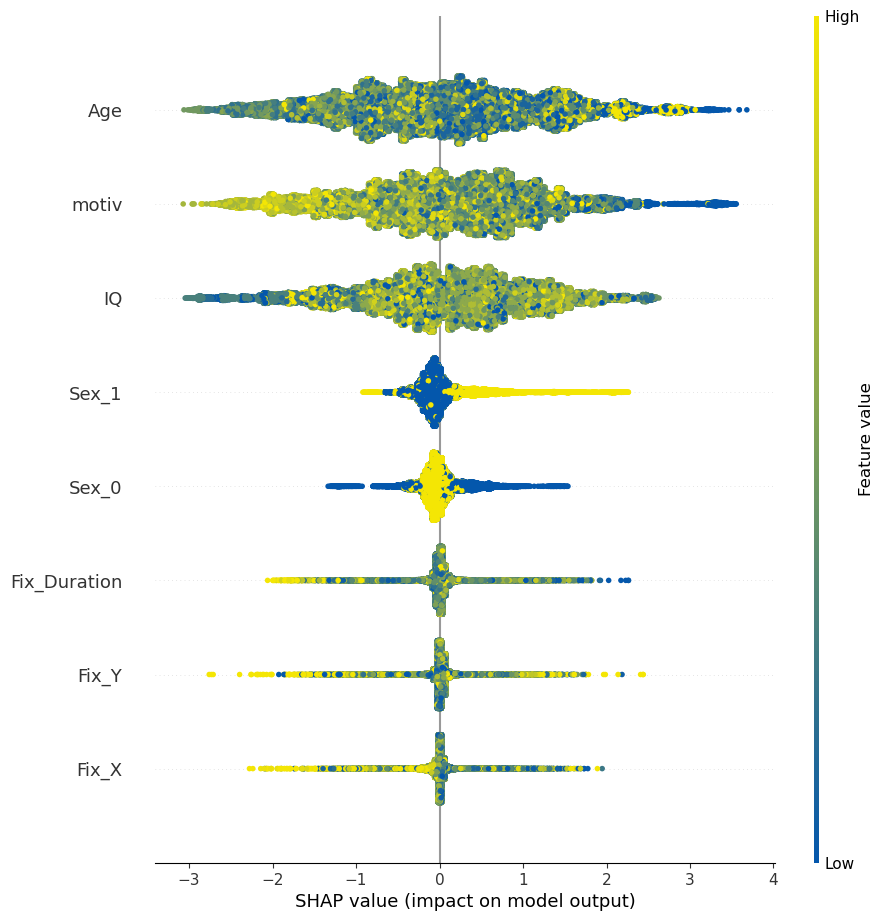

In [105]:


# Plot the summary without showing it
# plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 11),
                  feature_names=list(x_org.columns), 
#                   class_inds="original", 
                  class_names=[0, 1, 2, 3],
                  max_display=46
                 )

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")



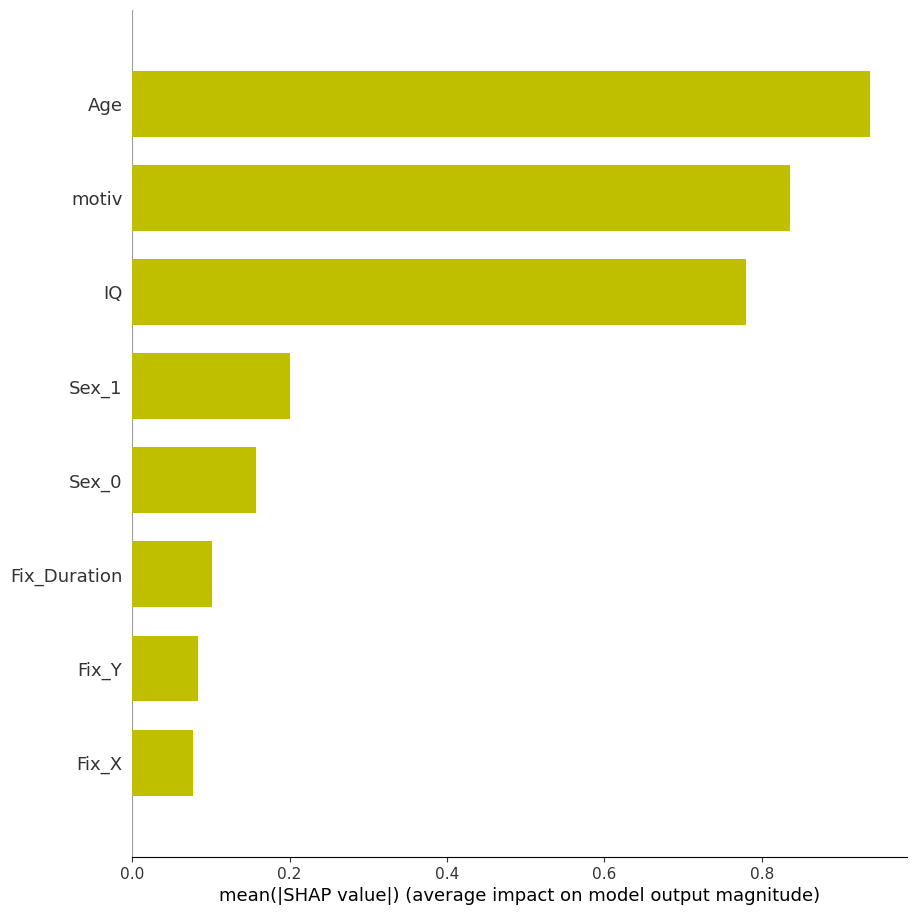

In [106]:


# plt.figure(figsize=(13, 10))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 11),
                  feature_names=list(x_org.columns), 
                  plot_type="bar",
                  color='y', 
                  max_display=46

                 )


In [107]:

len(list(x_org.columns))




8

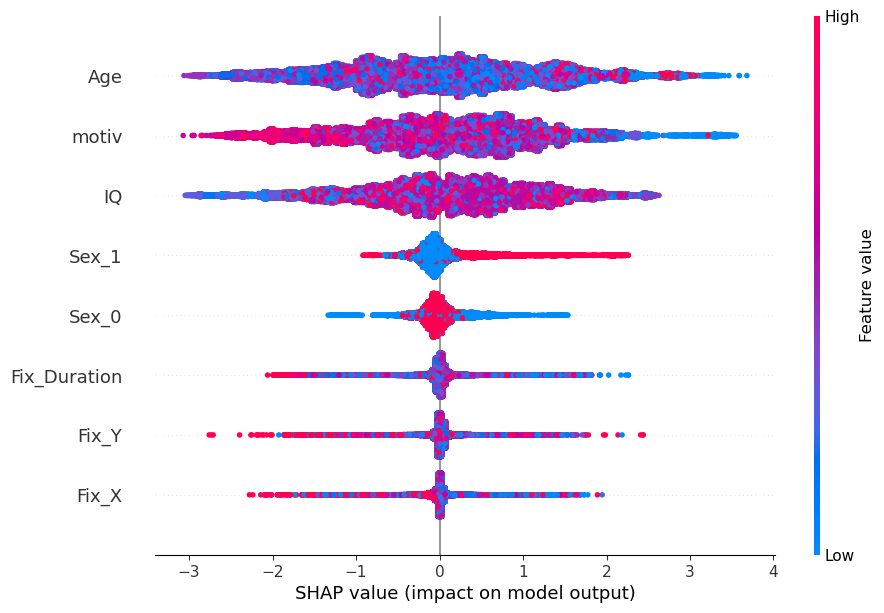

In [108]:
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 7),
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
#                   class_names=class_names,
#                   plot_type="scatter"
                 )

# # Change the colormap of the artists
# for fc in plt.gcf().get_children():
#     for fcc in fc.get_children():
#         if hasattr(fcc, "set_cmap"):
#             fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")



In [109]:


shap_values[0]



array([-1.74 , -0.004, -0.205, -0.298, -0.249,  0.02 ,  0.024, -2.544])

In [110]:


shap_values



array([[-1.74 , -0.004, -0.205, ...,  0.02 ,  0.024, -2.544],
       [-1.711, -0.015, -0.192, ..., -0.005, -0.027, -2.516],
       [-1.836,  0.025, -0.184, ...,  0.002, -0.01 , -2.475],
       ...,
       [ 1.315,  0.011,  0.114, ...,  0.531,  0.132,  2.074],
       [ 1.186,  0.72 ,  0.111, ...,  0.147,  0.412,  2.118],
       [ 1.253,  0.473,  0.107, ...,  0.044,  0.259,  1.961]])

In [111]:


features = x_org.columns


In [112]:


mas_per_features = {}
for f in features:
    mas_per_features[f] = []
    



In [113]:


for f in range(len(features)): 
    tmp = np.mean(np.abs(shap_values[:, f]), axis=0)
#     print(f"{features[f]}:  {tmp:.3f}")
    mas_per_features[features[f]].append(tmp)
# print(" ")
    
    
    

In [114]:

sorted_mas_per_features = sorted(mas_per_features.items(), key=lambda x:x[1], reverse=True)
# sorted_mas_per_features



In [115]:
A = []

for k,v in sorted_mas_per_features:
#     b_ = (np.asarray(v).sum()*100/tot_)
    b_ = np.asarray(v).sum()

    print(
        f"Sum of MAS of {k} = {b_: .3f}  "
    )
    A.append(np.asarray(v).sum())
    
    
    
    
    

Sum of MAS of Age =  0.938  
Sum of MAS of motiv =  0.836  
Sum of MAS of IQ =  0.780  
Sum of MAS of Sex_1 =  0.200  
Sum of MAS of Sex_0 =  0.157  
Sum of MAS of Fix_Duration =  0.102  
Sum of MAS of Fix_Y =  0.084  
Sum of MAS of Fix_X =  0.078  


In [116]:
sum(A[:15])

3.174706648435227

In [117]:
tot_ = sum(A)


for k,v in sorted_mas_per_features:
    b_ = (np.asarray(v).sum()*100/tot_)
    print(
        f"Sum of MAS of {k} = {b_: .3f}  "
    )
    
    
    

Sum of MAS of Age =  29.539  
Sum of MAS of motiv =  26.342  
Sum of MAS of IQ =  24.577  
Sum of MAS of Sex_1 =  6.309  
Sum of MAS of Sex_0 =  4.949  
Sum of MAS of Fix_Duration =  3.197  
Sum of MAS of Fix_Y =  2.637  
Sum of MAS of Fix_X =  2.449  


In [1]:

 29.539 + 26.342 +  24.577  +  6.309 + 4.949


91.716

In [ ]:


for k, v in mas_per_features.items():
    print(
        f"Sum of MAS of {k} = {np.asarray(v)} "
    )
    
    
    